In [1]:
y_pred = model.predict(X_test)
y_pred.shape()

NameError: name 'model' is not defined

In [2]:
get_ipython().system('pip install db-dtypes')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

CONFIGURE THE BIGQUERY SETTINGS

In [5]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [6]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data` 
"""
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [7]:
# Getting the no of columns to understand and choose the required ones
data.shape

(16833, 25)

inorder to know which columns are responsible or making a variation in predicting the unemployment claims,we need to find 
the correlation between them and drop the unnecessary colummns from the data frame.

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_16099/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


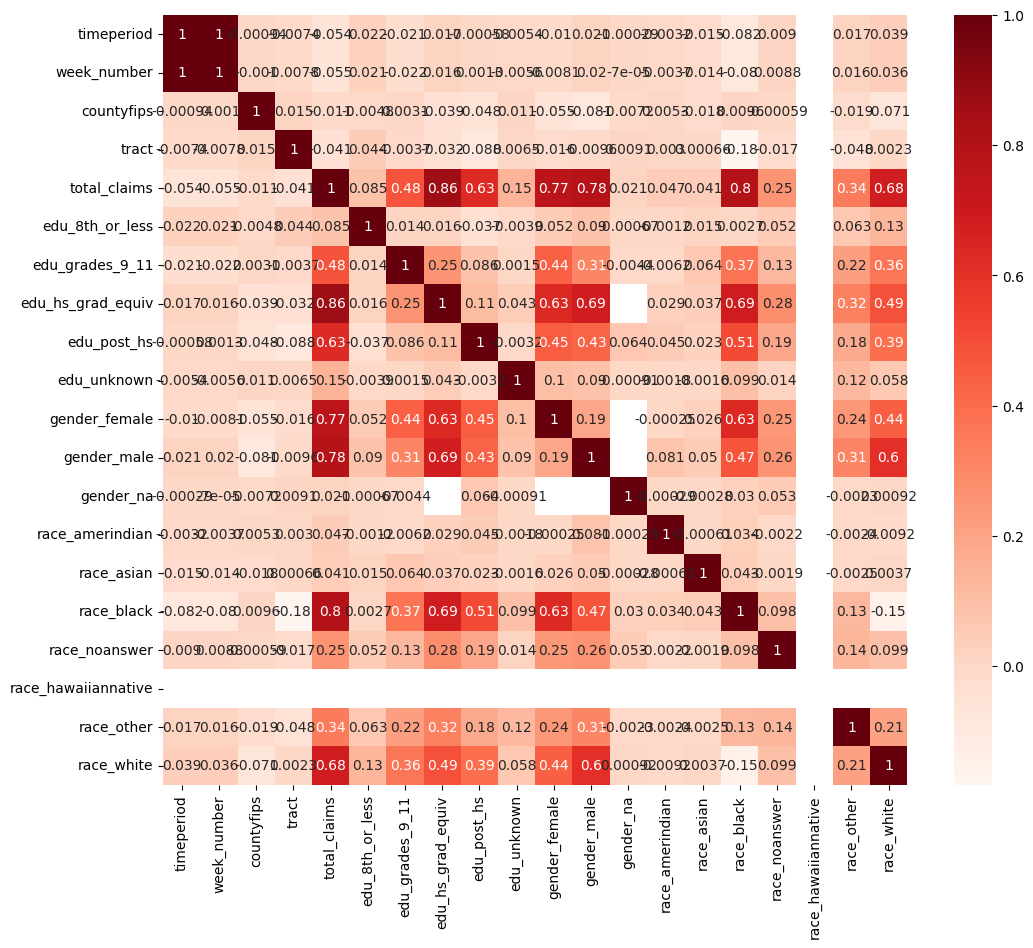

In [8]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
data['total_claims']
print("min",data['total_claims'].min(),"max",data['total_claims'].max())
print(data.columns)

min 10 max 170
Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [10]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

total_claims         1.000000
edu_hs_grad_equiv    0.863481
edu_post_hs          0.629552
gender_female        0.767174
gender_male          0.783093
race_black           0.795195
race_white           0.683659
Name: total_claims, dtype: float64


In [11]:
print(data.columns)
data=data[["uu_id","week_number","total_claims","edu_hs_grad_equiv","edu_post_hs","gender_female","gender_male","race_black","race_white"]]
data.columns
test=data

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [12]:
test=test.fillna(0,axis=0)
test["week_number"]= test["week_number"].astype("int")
test

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white
0,f013068de98db1470bd986137a0c6d23,16,22,14,0,0,0,11,0
1,21957d5517323845818d87623589e1ba,12,111,108,0,76,35,0,0
2,6a5609f385912113b6f1014b958ed748,13,39,0,0,0,0,39,0
3,46b2882ec4c373527ec33f7bd4f1388d,29,14,0,0,0,0,10,0
4,37495d17e82f7df326bfc2c4c090f7b7,15,155,69,83,90,65,135,0
...,...,...,...,...,...,...,...,...,...
16828,f35320206f3dd1ffc411e4ac127caf92,25,21,0,12,0,0,0,14
16829,f35320206f3dd1ffc411e4ac127caf92,35,22,13,0,0,0,0,0
16830,f35320206f3dd1ffc411e4ac127caf92,35,22,13,0,0,0,0,0
16831,bbcb018f0e5e49e13636f6e78ce9f60f,13,53,48,0,0,0,0,0


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
model = LinearRegression()
X_train=test.drop(["uu_id"],axis=1)
X_train=X_train.loc[X_train["week_number"]<=33]
y=X_train["total_claims"]
X_test=test.drop(["uu_id"],axis=1)
X_test = X_test.loc[X_test["week_number"]==34]
temp=test.loc[test["week_number"]==34]

In [14]:
model.fit(X_train,y)

LinearRegression()

In [15]:
X_test = X_test.loc[X_test["week_number"]==34]
X_test.head(10)
temp

,uu_id,week_number,total_claims,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white
5,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
6,25a57fe39e03c632125308737a7d3769,34,24,15,0,14,10,0,0
23,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
26,5e9480dba0f8de932f4d9fb55fa6b8b1,34,19,10,0,0,0,0,0
31,06e492b4f29d153af26c659d1f7da2a1,34,23,15,0,0,0,0,23
...,...,...,...,...,...,...,...,...,...
16721,adef8f4cb061376c14393d4fb9ab3f89,34,13,0,0,0,0,0,0
16740,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16743,447d5984bb8a8179bff002ccd1bba162,34,12,0,0,0,0,0,12
16809,06c78e49b4daedfeb808c42e58fb25e4,34,14,0,0,0,0,0,0


In [16]:
y_pred = model.predict(X_test)
y_pred.shape()

TypeError: 'tuple' object is not callable

In [17]:
y_pred = model.predict(X_test)
y_pred.shape

(826,)